# Code

In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import time
import os
import matplotlib.pyplot as plt
import time
import numpy as np
import random
import sys
import torch
import pickle
from pathlib import Path
from torch.utils.data import DataLoader
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!
sys.path.insert(0, '..')
from tqdm.notebook import tqdm
import seaborn as sns
import util.misc as utils
from dataset.data import (
    RNADataset,
    RNADatasetNT,
    RNADatasetNT500,
    EasyPosAugment,
    InteractionSelectionPolicy,
    EasyNegAugment,
    HardPosAugment,
    HardNegAugment,
    SmartNegAugment,
    HFDataset,
    HFDataLoader, 
    create_augment_list,
    plot_sample,
    seed_everything,
)
from train_binary_cl import seed_worker, obtain_train_dataset, obtain_val_dataset, undersample_df, obtain_policies_object, obtain_dataset_object
from config import *

<class 'transformers.tokenization_dna.DNATokenizer'>


In [4]:
EASY_PRETRAINING = False
FINETUNING = False
TRAIN_HQ = False
SPECIE = 'mouse'

scaling_factor = 5
min_n_groups_train = 5
max_n_groups_train = 80
min_n_groups_val = 80
max_n_groups_val = 80

# Esecuzione data loader train

In [5]:
if EASY_PRETRAINING:
    df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_easy.csv'))
    df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt_easy.csv'))
    subset_train_nt = os.path.join(rna_rna_files_dir, f"gene_pairs_training_nt_easy.txt")
else:
    if TRAIN_HQ:
        df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_HQ.csv'))
        df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt_HQ.csv'))
        subset_train_nt = os.path.join(rna_rna_files_dir, 'gene_pairs_training_nt_HQ.txt')
    else:
        df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))
        df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt.csv'))
        if FINETUNING:
            subset_train_nt = os.path.join(rna_rna_files_dir, f"gene_pairs_train_val_fine_tuning_nt.txt")
        else:
            subset_train_nt = os.path.join(rna_rna_files_dir, f"gene_pairs_training_nt.txt")

with open(subset_train_nt, "rb") as fp:  # Unpickling
    list_train = pickle.load(fp)

if SPECIE in ['human', 'mouse']:
    paris = pd.read_csv(os.path.join(processed_files_dir, f'paris.csv'))
    couples_to_keep = set(paris[paris.specie == SPECIE].couples)
    df_nt = df_nt[df_nt.couples_id.isin(couples_to_keep)]
    
vc_train = df_nt[df_nt.couples.isin(list_train)].interacting.value_counts()
assert vc_train[False]>vc_train[True]
unbalance_factor = 1 - (vc_train[False] - vc_train[True]) / vc_train[False]

if EASY_PRETRAINING:
    pos_multipliers = {15:0.2, 
            25:0.3,
            50:0.2, 
            100:0.23, 
            10_000_000: 0.07}

    neg_multipliers = {15:0.05, 
                    28:0.15,

                    40:0.08,
                    50:0.05,
                    60:0.1,

                    80:0.03,
                    90:0.03,
                    100:0.05,

                    110:0.05,

                    120:0.1,

                    140:0.05,
                    160:0.03,
                    180:0.03,
                    200:0.03,
                    220:0.02,
                    240:0.01,
                    260:0.01,

                    10_000_000: 0.1}

else:
    pos_multipliers = {15:0.2, 
                   25:0.3,
                   50:0.2, 
                   100:0.23,
                   100_000_000:0.07}
    neg_multipliers = pos_multipliers
    
policies_train = [
    EasyPosAugment(
        per_sample=0.5,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=pos_multipliers,
        height_multipliers=pos_multipliers,
    ),  
    SmartNegAugment(
        per_sample=unbalance_factor * 0.5,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=neg_multipliers,
        height_multipliers=neg_multipliers,
    ),
] 

dataset_train = RNADatasetNT(
        gene2info=df_genes_nt,
        interactions=df_nt,
        subset_file=subset_train_nt,
        augment_policies=policies_train,
        data_dir = os.path.join(embedding_dir, '32'),
        scaling_factor = scaling_factor,
        min_n_groups = min_n_groups_train,
        max_n_groups = max_n_groups_train,
)

/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1,2,16,17,18,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
np.sum(list(neg_multipliers.values()))

1.0

In [ ]:
#dataset_paris = dataset_train

In [122]:
n_epochs = 3
neg_len_1 = []
pos_len_1 = []
neg_len_2 = []
pos_len_2 = []
matrix_area_neg = []
matrix_area_pos = []

for epoch in tqdm(range(n_epochs)):
    for sample in tqdm(dataset_train, total=len(dataset_train)):
        box = sample.bbox
        if sample.interacting:
            pos_len_1.append(box.x2-box.x1)
            pos_len_2.append(box.y2-box.y1)
            matrix_area_pos.append((box.x2-box.x1)*(box.y2-box.y1))
        else:
            neg_len_1.append(box.x2-box.x1)
            neg_len_2.append(box.y2-box.y1)
            matrix_area_neg.append((box.x2-box.x1)*(box.y2-box.y1))
            
neg_len = neg_len_1+neg_len_2
pos_len = pos_len_1+pos_len_2
label_n = ['n' for i in range(len(neg_len))]
label_p = ['p' for i in range(len(pos_len))]
label = label_n + label_p
length = neg_len + pos_len
df_len = pd.DataFrame({'label':label, 'length':length})

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/28335 [00:00<?, ?it/s]

  0%|          | 0/28335 [00:00<?, ?it/s]

  0%|          | 0/28335 [00:00<?, ?it/s]

In [123]:
# plot_sample(sample, plot_interaction_negatives=True)

In [124]:
df_len.label.value_counts()

n    85044
p    84966
Name: label, dtype: int64

In [125]:
df_len.sort_values('length').head(500).label.value_counts()

n    480
p     20
Name: label, dtype: int64

In [126]:
(float(df_len.sort_values('length').quantile(0.2))/6)/80

0.9333333333333333

In [127]:
(float(df_len.sort_values('length').quantile(0.5))/6)/80

1.6666666666666667

In [128]:
#balance set
assert abs(df_len.label.value_counts().n/df_len.shape[0] - 0.5) < 0.05

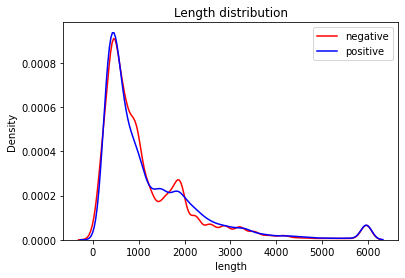

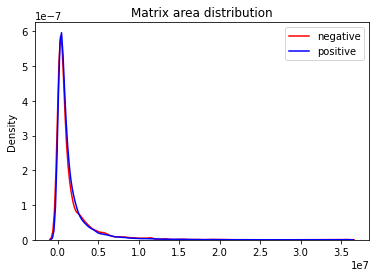

In [129]:
sns.kdeplot(df_len[df_len.label == 'n'].length, color = 'red', label = 'negative')
sns.kdeplot(df_len[df_len.label == 'p'].length, color = 'blue', label = 'positive')
plt.title(f'Length distribution')
plt.legend()
plt.show()
sns.kdeplot(matrix_area_neg, color = 'red', label = 'negative')
sns.kdeplot(matrix_area_pos, color = 'blue', label = 'positive')
plt.title(f'Matrix area distribution')
plt.legend()
plt.show()

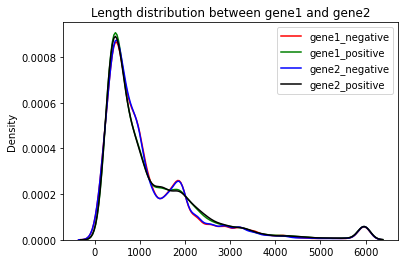

In [130]:
sns.kdeplot(neg_len_1, color = 'red', label = 'gene1_negative')
sns.kdeplot(pos_len_1, color = 'green', label = 'gene1_positive')
sns.kdeplot(neg_len_2, color = 'blue', label = 'gene2_negative')
sns.kdeplot(pos_len_2, color = 'black', label = 'gene2_positive')
plt.title(f'Length distribution between gene1 and gene2')
plt.legend()
plt.show()

In [131]:
small_l = df_len.length.quantile(0.1)
print(df_len[df_len['length'] < small_l].label.value_counts())
print('\n')
big_l = df_len.length.quantile(0.7)
print(df_len[df_len['length'] > big_l].label.value_counts())

n    9366
p    7008
Name: label, dtype: int64


p    26208
n    24740
Name: label, dtype: int64


# Validation set 

In [163]:
EASY_PRETRAINING = True
SPECIE = 'mouse'

In [164]:
if SPECIE in ['human', 'mouse']:
    paris = pd.read_csv(os.path.join(processed_files_dir, f'paris.csv'))
    couples_to_keep = set(paris[paris.specie == SPECIE].couples)

if EASY_PRETRAINING:
    df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_easy.csv'))
    df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt_easy.csv'))
    subset_val_nt = os.path.join(rna_rna_files_dir, f"gene_pairs_val_sampled_nt_easy.txt")
    if SPECIE in ['human', 'mouse']:
        df_nt = df_nt[df_nt.couples_id.isin(couples_to_keep)]
else:
    df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_HQ.csv'))
    df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt_HQ.csv'))
    if FINETUNING:
        subset_val_nt = os.path.join(rna_rna_files_dir, f"gene_pairs_test_sampled_nt_HQ.txt") # gene_pairs_test_sampled_nt.txt it is also HQ
        df500 = pd.read_csv(os.path.join(metadata_dir, f'test500.csv'))
    else:
        subset_val_nt = os.path.join(rna_rna_files_dir, f"gene_pairs_val_sampled_nt_HQ.txt") # gene_pairs_val_sampled_nt.txt it is also HQ
        df500 = pd.read_csv(os.path.join(metadata_dir, f'val500.csv'))

    with open(subset_val_nt, "rb") as fp:  # Unpickling
        list_val = pickle.load(fp)
        
    if SPECIE in ['human', 'mouse']:
        df_nt = df_nt[df_nt.couples_id.isin(couples_to_keep)]
    elif SPECIE == 'all':
        assert df500.shape[0] == df_nt[['couples', 'interacting', 'policy']].merge(df500, on = 'couples').shape[0]
        
    df500 = df_nt[['couples', 'interacting', 'policy']].merge(df500, on = 'couples')
    df500 = df500[df500.couples.isin(list_val)] # in questo modo ho quasi bilanciato del tutto, ma per avere un bilanciamento al 100% devo fare undersampling
    df500 = undersample_df(df500) #bilanciamento al 100%.

if EASY_PRETRAINING:
    pos_multipliers = {25:0.7, 50:0.2, 100:0.1}
    neg_multipliers = {33:0.3, 45:0.1, 55:0.1, 65:0.1,
                       80:0.05, 90:0.05, 100:0.05,
                       120:0.05, 150:0.02, 160:0.02,
                       170:0.02, 180:0.02, 190:0.02,
                       200:0.02, 210:0.02, 220:0.02}

    policies_val = [
        EasyPosAugment(
            per_sample=1,
            interaction_selection=InteractionSelectionPolicy.LARGEST,
            width_multipliers=pos_multipliers,
            height_multipliers=pos_multipliers,
        ),  
        SmartNegAugment(
            per_sample=1, # unbalance_factor
            interaction_selection=InteractionSelectionPolicy.LARGEST,
            width_multipliers=neg_multipliers,
            height_multipliers=neg_multipliers,
        ),
    ]

    dataset_val = RNADatasetNT(
        gene2info=df_genes_nt,
        interactions=df_nt,
        subset_file=subset_val_nt,
        augment_policies=policies_val,
        data_dir = os.path.join(embedding_dir, '32'),
        scaling_factor = scaling_factor,
        min_n_groups = min_n_groups_val,
        max_n_groups = max_n_groups_val,
    )

else:

    df500 = df500.sample(frac=1, random_state=23).reset_index(drop = True)
    assert df500.shape[0]>0

    dataset_val = RNADatasetNT500(
        df = df500,
        data_dir = os.path.join(embedding_dir, '32'),
        scaling_factor = scaling_factor,
        min_n_groups = min_n_groups_val,
        max_n_groups = max_n_groups_val,
    )
sampler_val = torch.utils.data.SequentialSampler(dataset_val)

/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1,2,16,17,18,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [165]:
np.sum(list(neg_multipliers.values()))

0.9600000000000001

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12529 [00:00<?, ?it/s]

  0%|          | 0/12529 [00:00<?, ?it/s]

  0%|          | 0/12529 [00:00<?, ?it/s]

median: 700.0


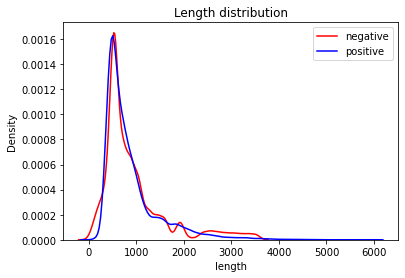

In [166]:
neg_len_1 = []
pos_len_1 = []
neg_len_2 = []
pos_len_2 = []
matrix_area_neg = []
matrix_area_pos = []

for epoch in tqdm(range(n_epochs)):
    for sample in tqdm(dataset_val, total=len(dataset_val)):
        box = sample.bbox
        if sample.interacting:
            pos_len_1.append(box.x2-box.x1)
            pos_len_2.append(box.y2-box.y1)
            matrix_area_pos.append((box.x2-box.x1)*(box.y2-box.y1))
        else:
            neg_len_1.append(box.x2-box.x1)
            neg_len_2.append(box.y2-box.y1)
            matrix_area_neg.append((box.x2-box.x1)*(box.y2-box.y1))
        
neg_len = neg_len_1+neg_len_2
pos_len = pos_len_1+pos_len_2
label_n = ['n' for i in range(len(neg_len))]
label_p = ['p' for i in range(len(pos_len))]
label = label_n + label_p
length = neg_len + pos_len
df_len = pd.DataFrame({'label':label, 'length':length})

print('median:', df_len.length.median())

sns.kdeplot(df_len[df_len.label == 'n'].length, color = 'red', label = 'negative')
sns.kdeplot(df_len[df_len.label == 'p'].length, color = 'blue', label = 'positive')
plt.title(f'Length distribution')
plt.legend()

# Esecuzione data loader external dataset

In [15]:
dataset = 'splash'

df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_{dataset}.csv'))
df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt_{dataset}.csv'))
data_dir = os.path.join(rna_rna_files_dir, f'{dataset}')
file_training = os.path.join(data_dir, 'gene_pairs_training.txt')
with open(file_training, "rb") as fp:   # Unpickling
    train_couples = pickle.load(fp)

    
file_test = os.path.join(data_dir, 'gene_pairs_test.txt')
with open(file_test, "rb") as fp:   # Unpickling
    test_couples = pickle.load(fp)
    
train_nt = df_nt[df_nt.couples_id.isin(train_couples)]
test_nt = df_nt[df_nt.couples_id.isin(test_couples)]

In [16]:
df_nt.interacting.value_counts()

True     1106
False     999
Name: interacting, dtype: int64

In [17]:
train_nt.interacting.value_counts()

True     777
False    725
Name: interacting, dtype: int64

In [18]:
test_nt.interacting.value_counts()

True     329
False    300
Name: interacting, dtype: int64

In [19]:
scaling_factor = 5

if dataset == 'splash':
    pos_multipliers = {5:0.7, 15:0.2, 50:0.1, 100:0.1}
    neg_multipliers = {5:0.7, 15:0.2, 50:0.1, 100:0.1}

elif dataset == 'mario':
    pos_multipliers = {5:0.7, 15:0.2, 50:0.1, 100:0.1}
    neg_multipliers = {5:0.1, 6:0.5, 15:0.2, 50:0.13, 100:0.13}

elif dataset == 'ricseq':
    pos_multipliers = {5:0.7, 25:0.1, 70:0.1, 100:0.1}
    neg_multipliers = {5:0.02, 10:0.85, 
                       70:0.02, 80:0.02, 90:0.02,
                       100:0.2}

vc_train = train_nt.interacting.value_counts()
if vc_train[False]>vc_train[True]:
    unbalance_factor = 1 - (vc_train[False] - vc_train[True]) / vc_train[False]
    policies_train = obtain_policies_object(0.25, 0.25*unbalance_factor, pos_multipliers, neg_multipliers)
elif vc_train[False]<vc_train[True]:
    unbalance_factor = 1 - (vc_train[True] - vc_train[False]) / vc_train[True]
    policies_train = obtain_policies_object(0.25*unbalance_factor, 0.25, pos_multipliers, neg_multipliers)
elif vc_train[True]==vc_train[True]:
    unbalance_factor = 1

dataset_train  = obtain_dataset_object(policies_train, df_genes_nt, df_nt, '', scaling_factor, min_n_groups_train, max_n_groups_train)

In [20]:
if dataset == 'ricseq':
    dataset_ricseq = dataset_train
elif dataset == 'splash':
    dataset_splash = dataset_train

In [132]:
n_epochs = 10
neg_len_1 = []
pos_len_1 = []
neg_len_2 = []
pos_len_2 = []
matrix_area_neg = []
matrix_area_pos = []

for epoch in tqdm(range(n_epochs)):
    for sample in tqdm(dataset_train, total=len(dataset_train)):
        box = sample.bbox
        if sample.interacting:
            pos_len_1.append(box.x2-box.x1)
            pos_len_2.append(box.y2-box.y1)
            matrix_area_pos.append((box.x2-box.x1)*(box.y2-box.y1))
        else:
            neg_len_1.append(box.x2-box.x1)
            neg_len_2.append(box.y2-box.y1)
            matrix_area_neg.append((box.x2-box.x1)*(box.y2-box.y1))
            
neg_len = neg_len_1+neg_len_2
pos_len = pos_len_1+pos_len_2
label_n = ['n' for i in range(len(neg_len))]
label_p = ['p' for i in range(len(pos_len))]
label = label_n + label_p
length = neg_len + pos_len
df_len = pd.DataFrame({'label':label, 'length':length})

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/6620 [00:00<?, ?it/s]

  0%|          | 0/6620 [00:00<?, ?it/s]

  0%|          | 0/6620 [00:00<?, ?it/s]

  0%|          | 0/6620 [00:00<?, ?it/s]

  0%|          | 0/6620 [00:00<?, ?it/s]

  0%|          | 0/6620 [00:00<?, ?it/s]

  0%|          | 0/6620 [00:00<?, ?it/s]

  0%|          | 0/6620 [00:00<?, ?it/s]

  0%|          | 0/6620 [00:00<?, ?it/s]

  0%|          | 0/6620 [00:00<?, ?it/s]

In [133]:
df_len.label.value_counts()

n    66940
p    65460
Name: label, dtype: int64

In [134]:
df_len.sort_values('length').head(500).label.value_counts()

n    294
p    206
Name: label, dtype: int64

In [135]:
#balance set
assert abs(df_len.label.value_counts().n/df_len.shape[0] - 0.5) < 0.05

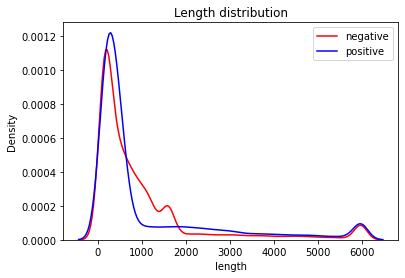

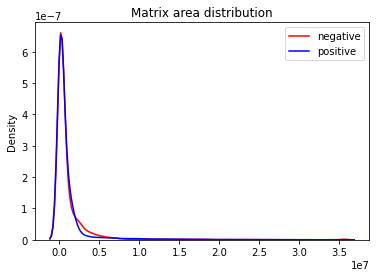

In [136]:
sns.kdeplot(df_len[df_len.label == 'n'].length, color = 'red', label = 'negative')
sns.kdeplot(df_len[df_len.label == 'p'].length, color = 'blue', label = 'positive')
plt.title(f'Length distribution')
plt.legend()
plt.show()
sns.kdeplot(matrix_area_neg, color = 'red', label = 'negative')
sns.kdeplot(matrix_area_pos, color = 'blue', label = 'positive')
plt.title(f'Matrix area distribution')
plt.legend()
plt.show()

### Validation

In [170]:
dataset = 'mario'

In [150]:
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_{dataset}.csv'))
data_dir = os.path.join(rna_rna_files_dir, f'{dataset}')

file_test = os.path.join(data_dir, 'gene_pairs_test.txt')
with open(file_test, "rb") as fp:   # Unpickling
    test_couples = pickle.load(fp)

df500 = pd.read_csv(os.path.join(metadata_dir, f'{dataset}500.csv'))
assert df500.shape[0] == df_nt[['couples', 'couples_id', 'interacting', 'policy']].merge(df500, on = 'couples').shape[0]
df500 = df_nt[['couples', 'interacting', 'policy', 'couples_id']].merge(df500, on = 'couples')
df500 = df500[df500.couples_id.isin(test_couples)]
df500 = df500[df500.policy.isin(['easypos', 'smartneg'])]
df500 = undersample_df(df500)

df500 = df500.sample(frac=1, random_state=23).reset_index(drop = True)
assert df500.shape[0]>0

dataset_val = RNADatasetNT500(
    df = df500,
    data_dir = os.path.join(embedding_dir, '32'),
    scaling_factor = scaling_factor,
    min_n_groups = min_n_groups_val,
    max_n_groups = max_n_groups_val,
)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

median: 500.0


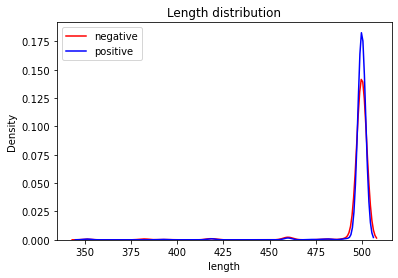

In [151]:
n_epochs = 10
neg_len_1 = []
pos_len_1 = []
neg_len_2 = []
pos_len_2 = []
matrix_area_neg = []
matrix_area_pos = []

for epoch in tqdm(range(n_epochs)):
    for sample in tqdm(dataset_val, total=len(dataset_val)):
        box = sample.bbox
        if sample.interacting:
            pos_len_1.append(box.x2-box.x1)
            pos_len_2.append(box.y2-box.y1)
            matrix_area_pos.append((box.x2-box.x1)*(box.y2-box.y1))
        else:
            neg_len_1.append(box.x2-box.x1)
            neg_len_2.append(box.y2-box.y1)
            matrix_area_neg.append((box.x2-box.x1)*(box.y2-box.y1))
        
neg_len = neg_len_1+neg_len_2
pos_len = pos_len_1+pos_len_2
label_n = ['n' for i in range(len(neg_len))]
label_p = ['p' for i in range(len(pos_len))]
label = label_n + label_p
length = neg_len + pos_len
df_len = pd.DataFrame({'label':label, 'length':length})

assert abs(df_len.label.value_counts().n/df_len.shape[0] - 0.5) < 0.05

print('median:', df_len.length.median())

sns.kdeplot(df_len[df_len.label == 'n'].length, color = 'red', label = 'negative')
sns.kdeplot(df_len[df_len.label == 'p'].length, color = 'blue', label = 'positive')
plt.title(f'Length distribution')
plt.legend()

# Combined dataset 

In [37]:
import torch
from torch.utils.data import DataLoader, Dataset, ConcatDataset

# Assuming you have three PyTorch datasets: dataset_1, dataset_2, dataset_3

class CombinedDataset(Dataset):
    def __init__(self, datasets):
        self.datasets = datasets
        self.total_lengths = [len(dataset) for dataset in datasets]
        self.total_length = sum(self.total_lengths)

    def __getitem__(self, index):
        # Calculate the dataset index and sample index within that dataset
        dataset_index = 0
        while index >= self.total_lengths[dataset_index]:
            index -= self.total_lengths[dataset_index]
            dataset_index += 1
        return self.datasets[dataset_index][index]

    def __len__(self):
        return self.total_length

# Combine the datasets into one
combined_dataset = CombinedDataset([dataset_ricseq, dataset_splash, dataset_paris])

# Define a custom data loader that samples an equal number of samples from each dataset
class EqualBatchSampler(torch.utils.data.Sampler):
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.num_datasets = len(self.dataset.datasets)
        self.dataset_lengths = [len(ds) for ds in self.dataset.datasets]

    def __iter__(self):
        while True:
            indices = []
            for i in range(self.num_datasets):
                indices.extend(torch.randperm(self.dataset_lengths[i]).tolist())

            # Yield batches with an equal number of samples from each dataset
            for i in range(0, len(indices), self.batch_size * self.num_datasets):
                yield indices[i:i + self.batch_size * self.num_datasets]

    def __len__(self):
        return len(self.dataset) // self.batch_size

# Create a data loader using the combined dataset and custom sampler
batch_size = 32  # You can set your desired batch size here
custom_sampler = EqualBatchSampler(combined_dataset, batch_size)
custom_data_loader = DataLoader(
    combined_dataset,
    batch_sampler=custom_sampler, 
    collate_fn=utils.collate_fn_nt3
)

In [53]:
import torch
from torch.utils.data import Dataset, ConcatDataset, DataLoader

# Custom dataset class to undersample the first two datasets
class UndersampledDataset(Dataset):
    def __init__(self, datasets):
        self.datasets = datasets
        self.length = min(len(dataset) for dataset in datasets)

    def __len__(self):
        return self.length * len(self.datasets)

    def __getitem__(self, index):
        dataset_idx = index // self.length
        sample_idx = index % self.length
        return self.datasets[dataset_idx][sample_idx]

In [55]:
n_epochs = 10
batch_size = 32

for epoch in tqdm(range(n_epochs)):

    # Create UndersampledDataset with the concatenated dataset
    undersampled_dataset = UndersampledDataset([dataset_ricseq, dataset_splash, dataset_paris])
    # Create DataLoader using the undersampled dataset
    custom_data_loader = DataLoader(undersampled_dataset, batch_size=batch_size, shuffle=True, collate_fn=utils.collate_fn_nt3)

    neg_len_1 = []
    pos_len_1 = []
    neg_len_2 = []
    pos_len_2 = []
    matrix_area_neg = []
    matrix_area_pos = []

    for s, targets in custom_data_loader: #tqdm(custom_data_loader, total = len(custom_data_loader)):
        for sample in targets:
            box = sample['bbox']
            if sample['interacting']==1:
                pos_len_1.append(box.x2-box.x1)
                pos_len_2.append(box.y2-box.y1)
                matrix_area_pos.append((box.x2-box.x1)*(box.y2-box.y1))
            else:
                neg_len_1.append(box.x2-box.x1)
                neg_len_2.append(box.y2-box.y1)
                matrix_area_neg.append((box.x2-box.x1)*(box.y2-box.y1))

neg_len = neg_len_1+neg_len_2
pos_len = pos_len_1+pos_len_2
label_n = ['n' for i in range(len(neg_len))]
label_p = ['p' for i in range(len(pos_len))]
label = label_n + label_p
length = neg_len + pos_len
df_len = pd.DataFrame({'label':label, 'length':length})

  0%|          | 0/10 [00:00<?, ?it/s]

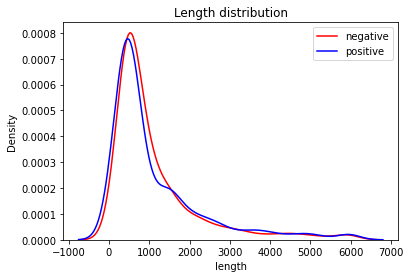

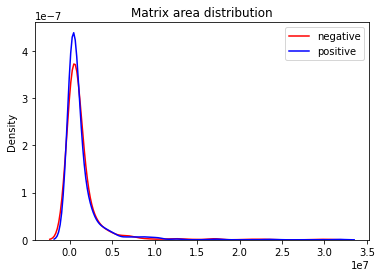

In [56]:
sns.kdeplot(df_len[df_len.label == 'n'].length, color = 'red', label = 'negative')
sns.kdeplot(df_len[df_len.label == 'p'].length, color = 'blue', label = 'positive')
plt.title(f'Length distribution')
plt.legend()
plt.show()
sns.kdeplot(matrix_area_neg, color = 'red', label = 'negative')
sns.kdeplot(matrix_area_pos, color = 'blue', label = 'positive')
plt.title(f'Matrix area distribution')
plt.legend()
plt.show()